In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

def make_bands_x(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
 
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem fro all k
    for j, k in enumerate(momenta):
        parameters['k'] = k
        Phi, H, P, deleted_indices = operators_diagB(parameters)
        bands[j] = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-7, sigma = 0.000001, which = 'LM',return_eigenvectors = False)

    return momenta,bands

## We want to adapt the ribbon function to use it for diagonal edges 
    - We need a width of more that 4
    - We can make a single horizontal line, make a shift and impose the bc on the two final sites

In [3]:
def operators_diag(parameters,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''

    W = parameters['W']
    Ny = parameters['Ny']
    k = parameters['k']       
    Nx = parameters['W'] + parameters['Ny']+ 1
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []

    for (x,y) in [(x,y) for y in range(Ny-1) for x in range(Nx)]:
        
        row_Tx += [x + Nx*y]
        col_Tx += [((x+1)%Nx) + y*Nx]
        #data_Tx += [(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        data_Tx += [1]
        
        row_Ty += [x + Nx*y]
        col_Ty += [x + Nx*((y+1)%Ny)]
        data_Ty += [1]
        
    for x in range(Nx):
        
        row_Tx += [x + Nx*(Ny-1)]
        col_Tx += [((x+1)%Nx) + (Ny-1)*Nx]
        data_Tx += [(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [x + Nx*(Ny-1)]
        col_Ty += [(x - Ny) % Nx ] #Shift to the left! 
        data_Ty += [np.exp(-1j*k*Ny*np.sqrt(2))]

    
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    x1 = np.arange(1,Ny+1)
    x2 = np.arange(W,Ny+W)
    xx = np.concatenate((x1,x2))
    y1 = np.arange(0,Ny)
    yy = np.concatenate((y1,y1))
    
    edge_points = np.stack((xx,yy))
    normal_angles1 = 3*pi/4*np.ones(len(edge_points[0])//2)
    normal_angles2 = -1*pi/4*np.ones(len(edge_points[0])//2)
    #normal_angles2 = 3*pi/4*np.ones(len(edge_points[0])//2)
    normal_angles = np.concatenate((normal_angles1,normal_angles2))
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
        
    theta = parameters['theta']
    indices_to_delete = []
    

    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        return np.abs(x-(W+1)/2-y)/(W/2)
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x,y)>1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1
        
    # Transforming the sparse matrix into dense to delete spins is probably not the best way to do this
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [4]:
thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
Ny = 1
i = -1 ### selected value of theta
W = 51 
k = 0
Nx = Ny+W+1
parameters = dict(
    W = W,
    Ny = Ny,
    k = k,
    theta = -(pi/2)*(thetas[i]/100),
)

Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_diag(parameters, return_shape = True)

/tmp/ipykernel_50773/2710145302.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


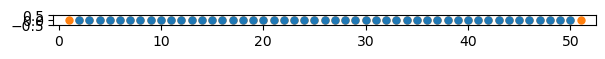

In [5]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
ax.scatter(spinup_shape[0],spinup_shape[1], s = 25)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 25,zorder=-1)
#ax.scatter(X,Y,zorder=-2, s = 25)
ax.set_aspect('equal')
ax.set_ylim(-0.5,Ny-0.5)
ax.set_xlim(-0.5,W+Ny+0.5)
fig.show()
#fig.savefig('shape.pdf')

In [6]:
nbands = 20
momenta, bands = make_bands_x(parameters, number_of_bands = nbands, number_of_points = 2001, kmin = -pi/np.sqrt(2),kmax = pi/np.sqrt(2))

NameError: name 'operators_diagB' is not defined

NameError: name 'momenta' is not defined

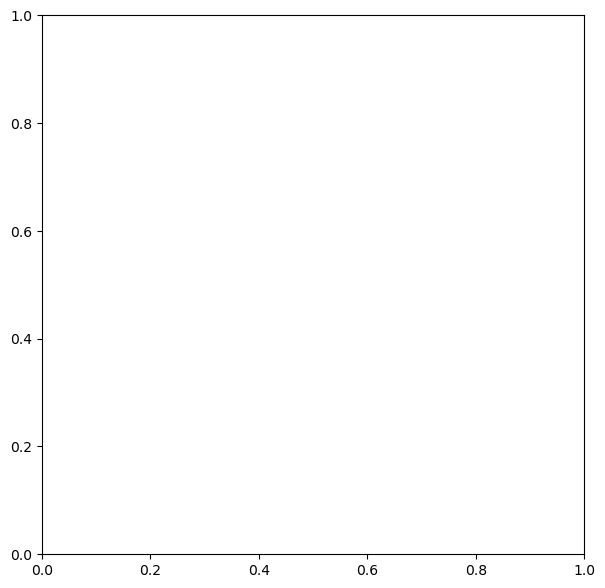

In [7]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)

#fig.savefig('diagonal_intermediate.pdf')

/tmp/ipykernel_11081/842653636.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (7,7))


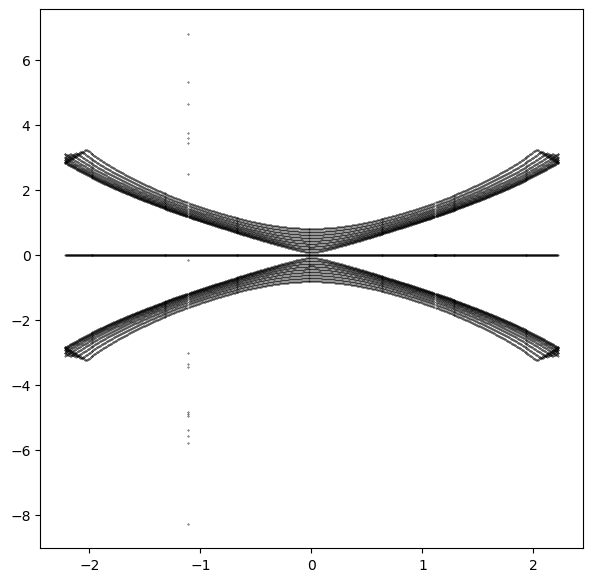

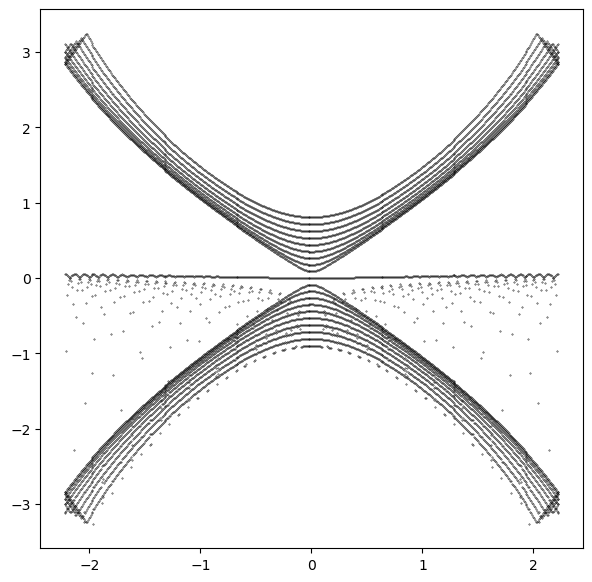

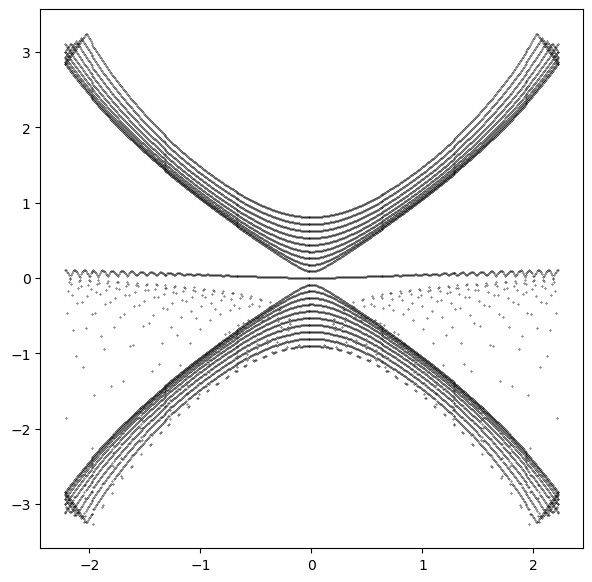

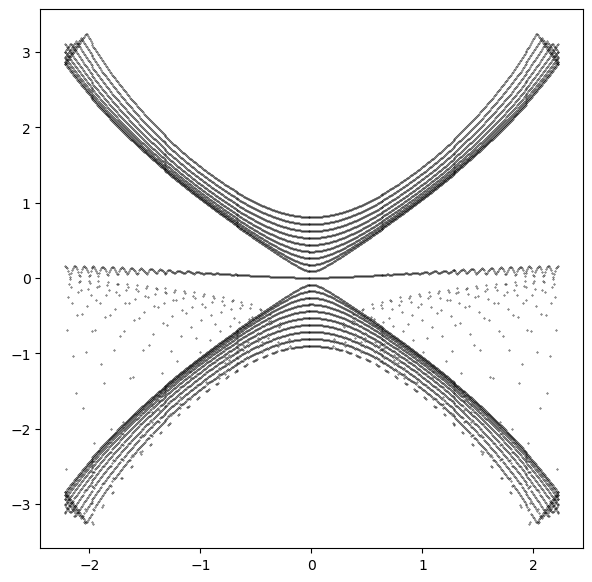

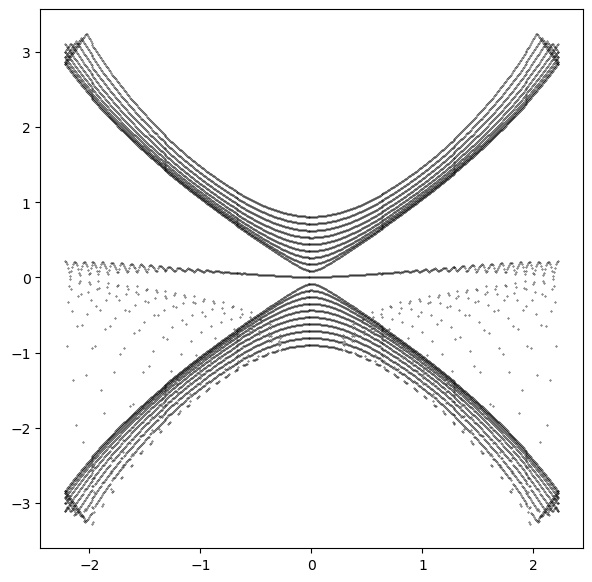

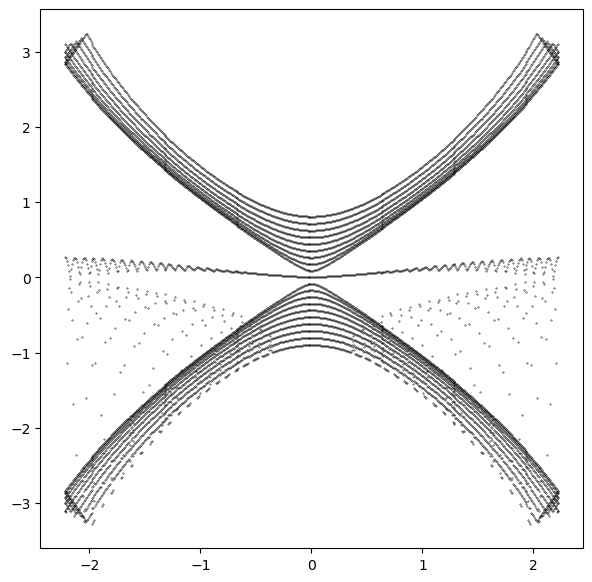

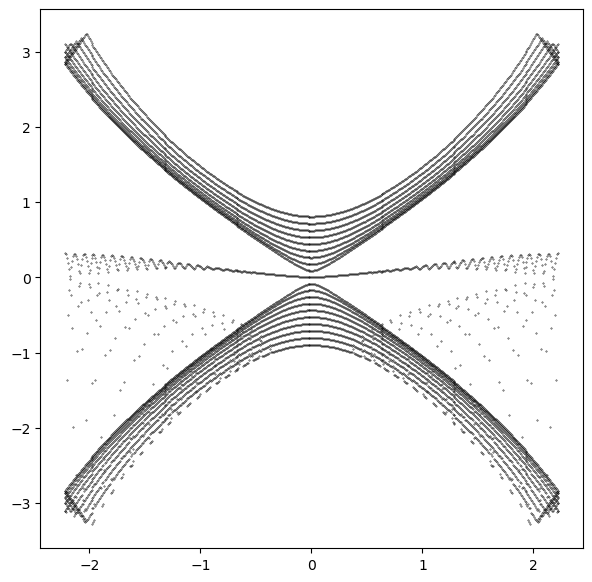

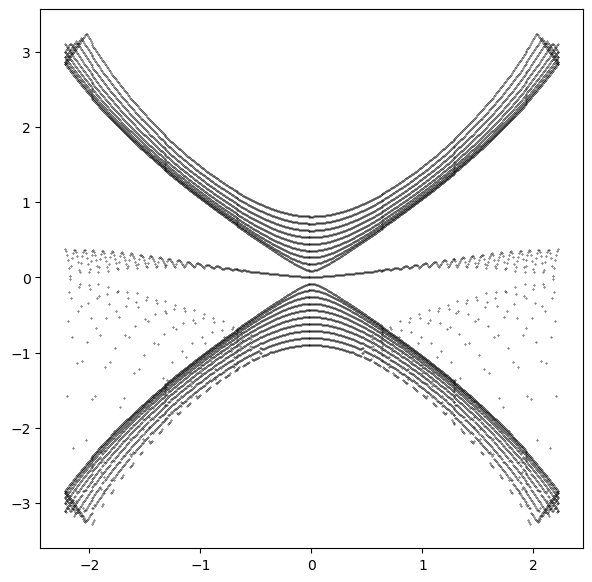

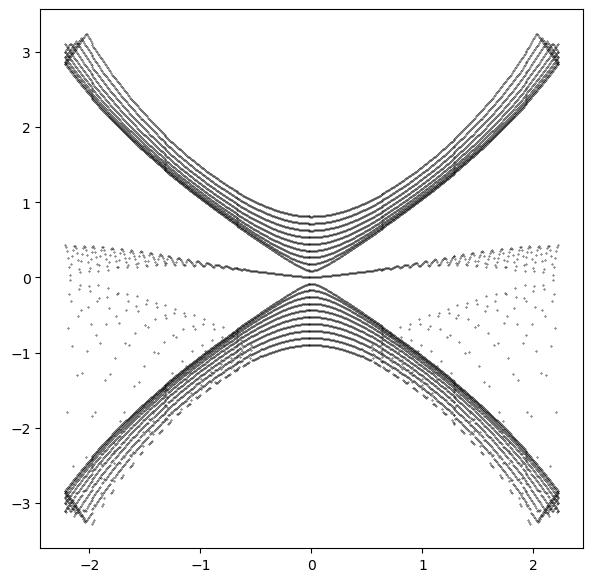

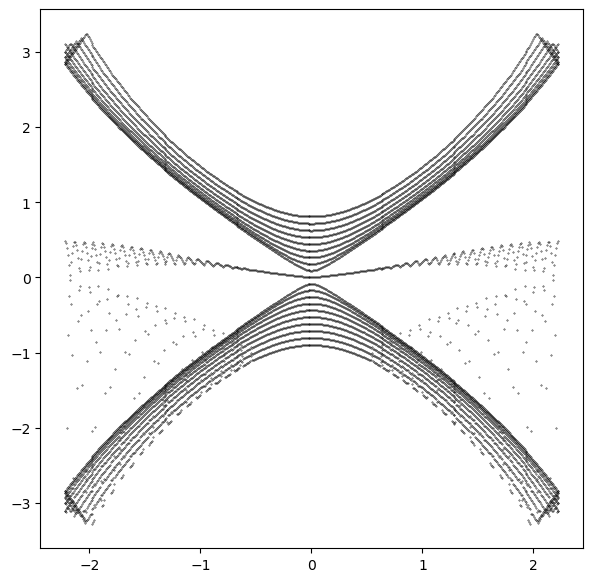

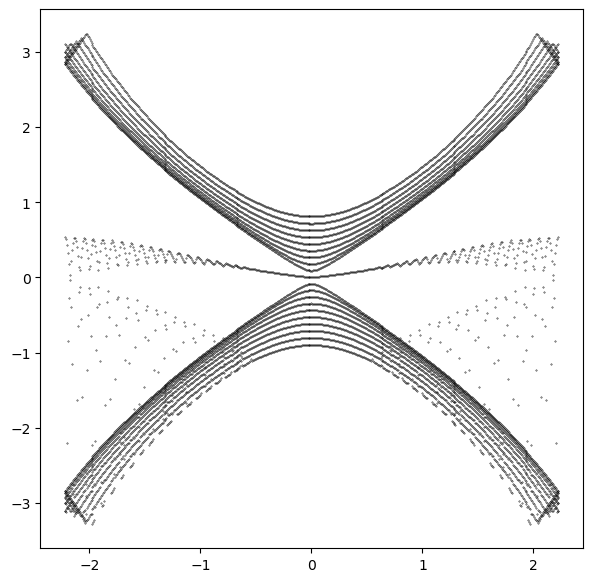

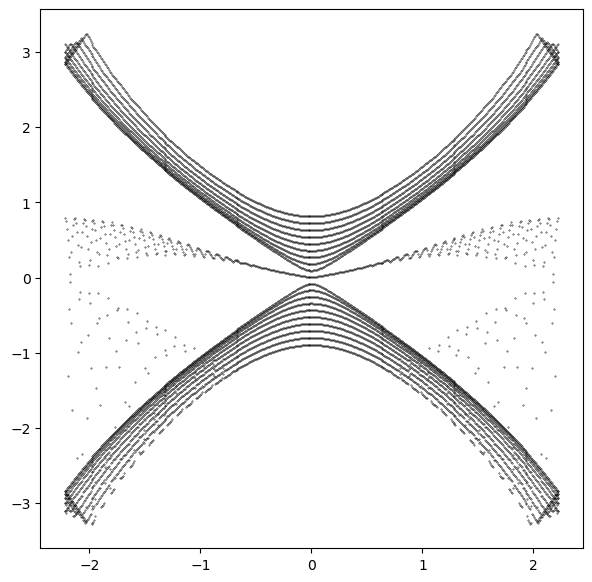

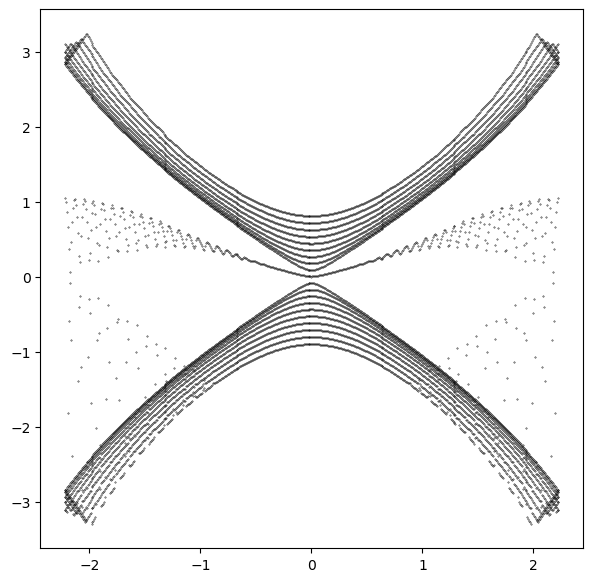

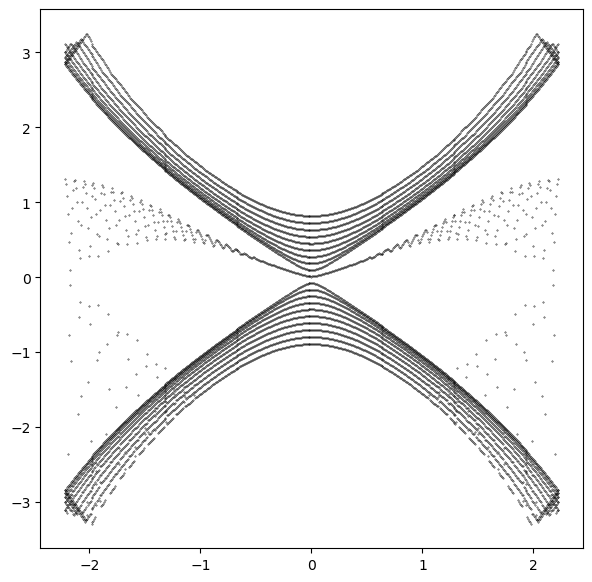

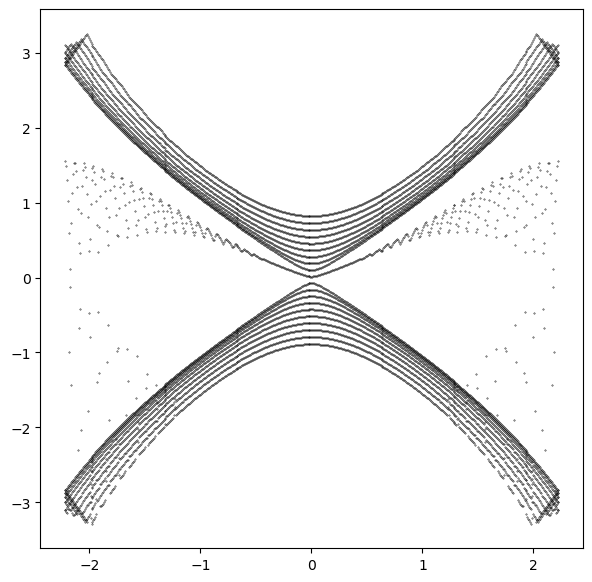

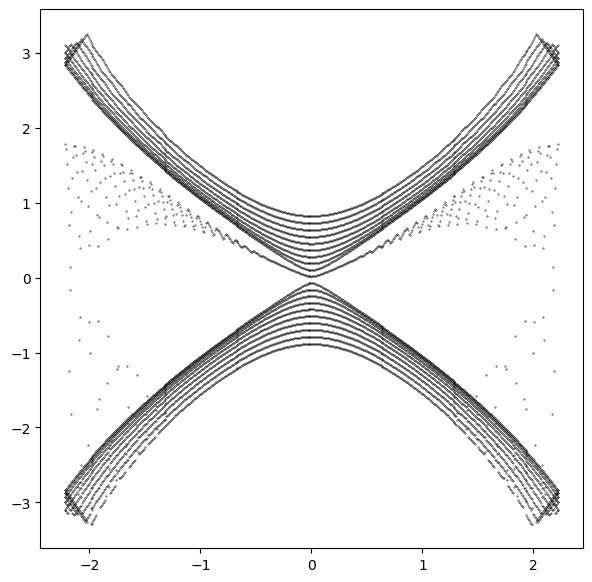

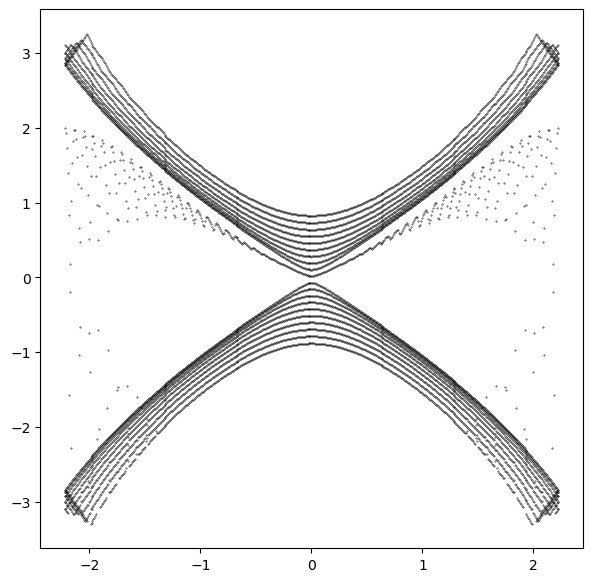

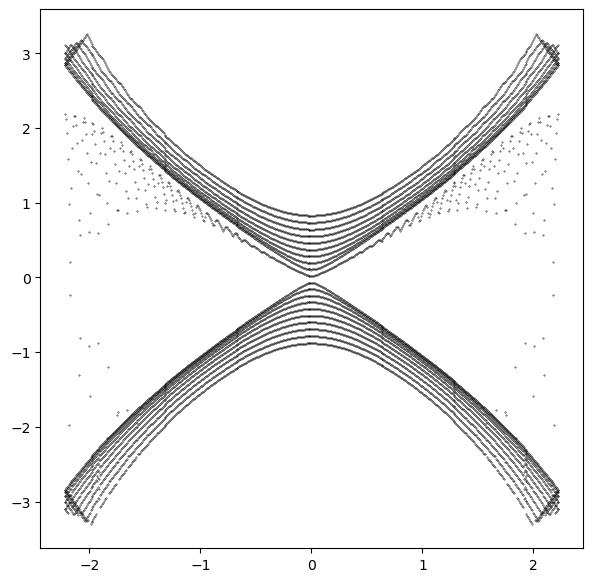

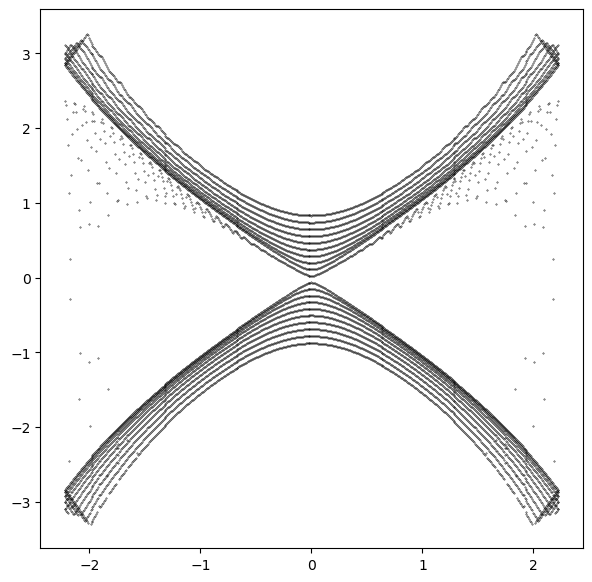

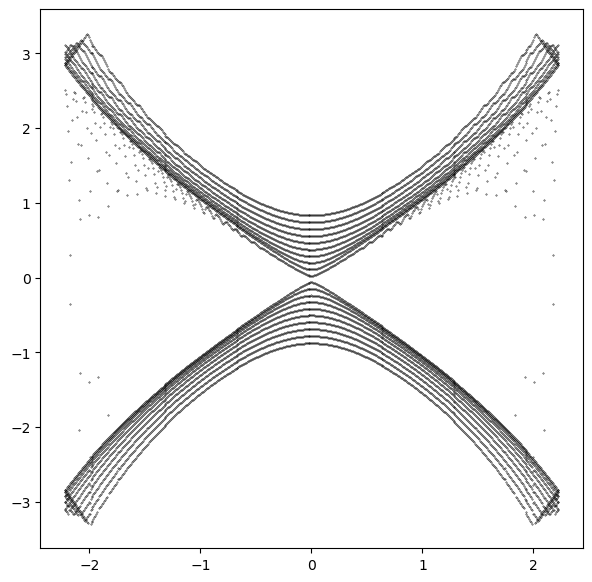

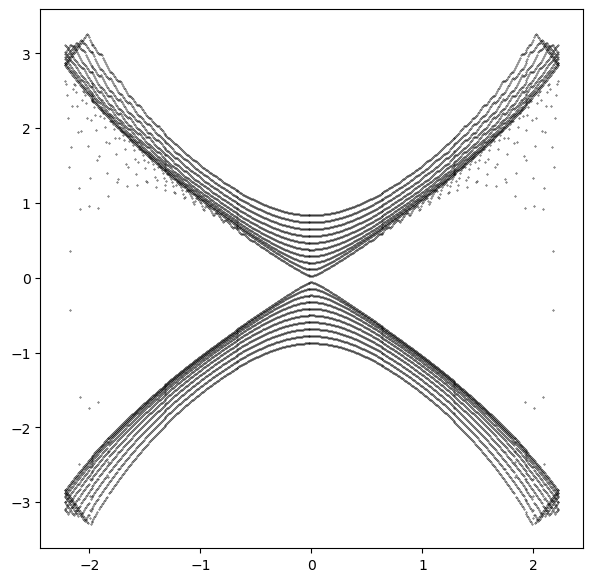

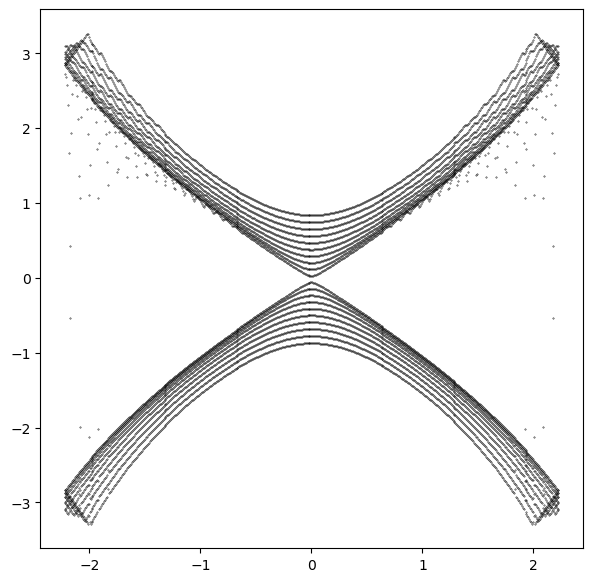

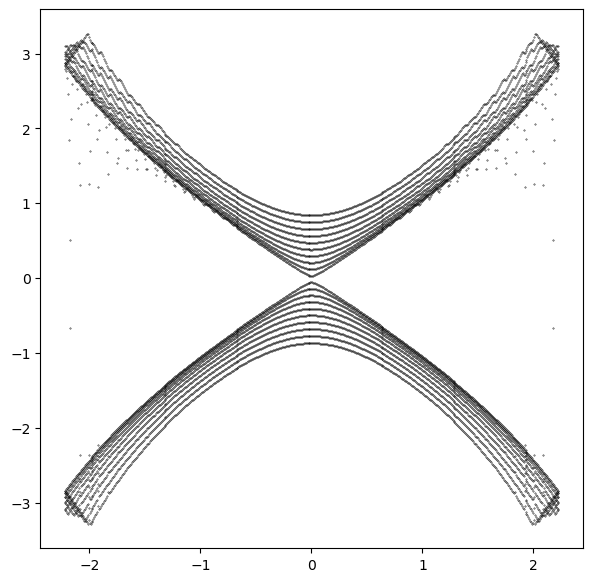

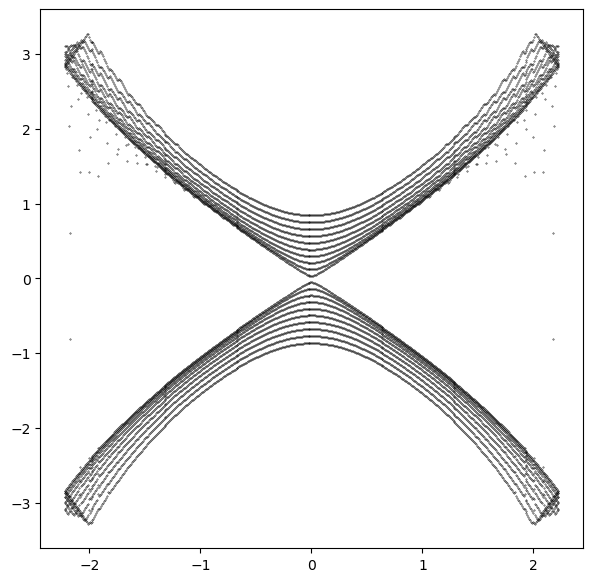

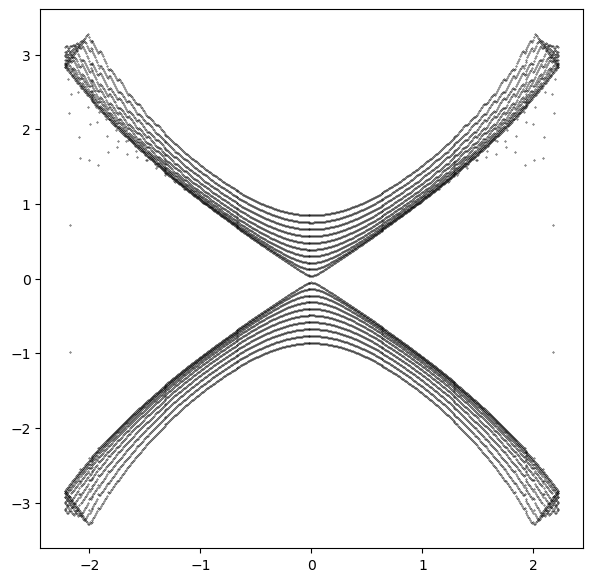

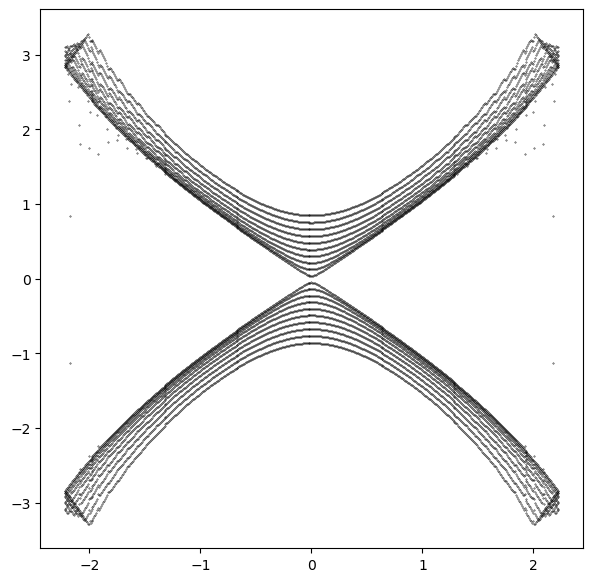

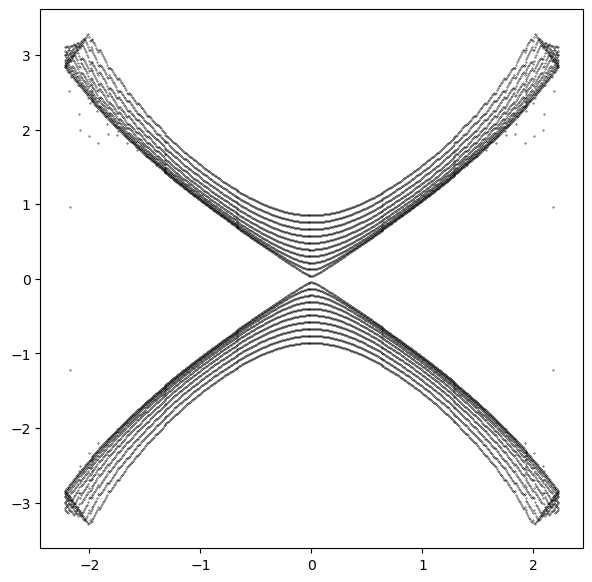

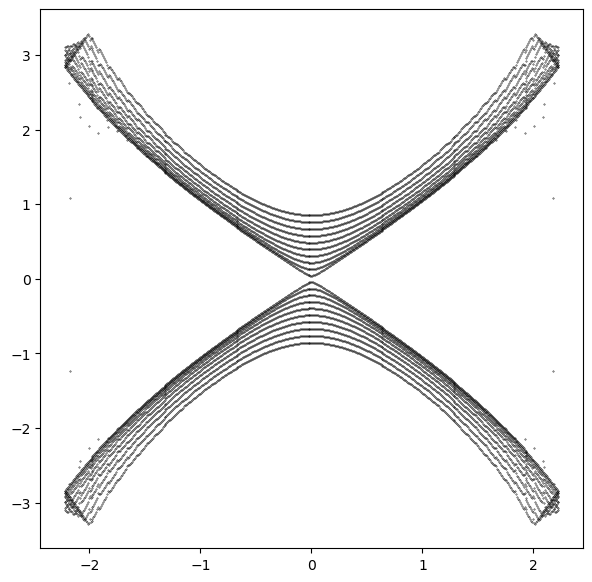

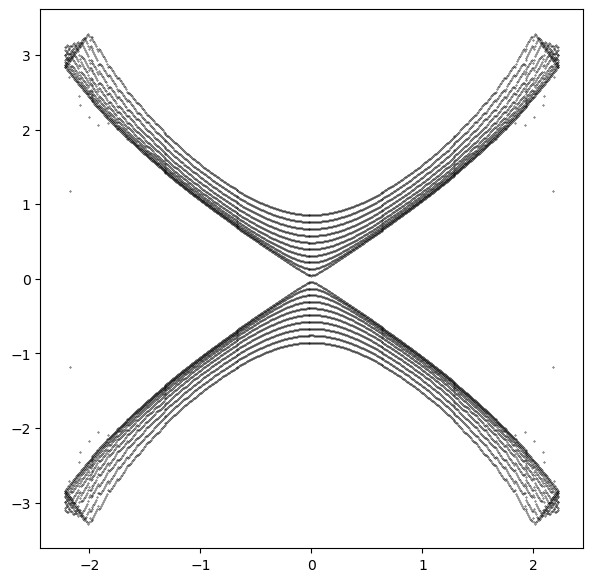

In [12]:
for i in range(len(thetas)):
    parameters['theta'] = -(pi/2)*(thetas[i]/100)
    momenta, bands = make_bands_x(parameters, number_of_bands = nbands, number_of_points = 501, kmin = -pi/np.sqrt(2),kmax = pi/np.sqrt(2))

    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot(111)
    for i in range(nbands):
        ax.scatter(momenta, bands[:,i], c = 'k', s = 0.1)
#ax.axhline(0, c = 'k')

In [35]:
def operators_diagB(parameters,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''

    W = parameters['W']
    Ny = parameters['Ny']
    k = parameters['k']       
    Nx = parameters['W'] + parameters['Ny']+ 1
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []

    for (x,y) in [(x,y) for y in range(Ny-1) for x in range(Nx)]:
        
        row_Tx += [x + Nx*y]
        col_Tx += [((x+1)%Nx) + y*Nx]
        #data_Tx += [(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        data_Tx += [1]
        
        row_Ty += [x + Nx*y]
        col_Ty += [x + Nx*((y+1)%Ny)]
        data_Ty += [1]
        
    for x in range(Nx):
        
        row_Tx += [x + Nx*(Ny-1)]
        col_Tx += [((x+1)%Nx) + (Ny-1)*Nx]
        data_Tx += [(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [x + Nx*(Ny-1)]
        col_Ty += [(x - Ny) % Nx ] #Shift to the left! 
        data_Ty += [np.exp(-1j*k*Ny*np.sqrt(2))]

    
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    x1 = np.arange(1,Ny+1)
    x2 = np.arange(W,Ny+W)
    xx = np.concatenate((x1,x2))
    y1 = np.arange(0,Ny)
    yy = np.concatenate((y1,y1))
    
    edge_points = np.stack((xx,yy))
    normal_angles1 = 3*pi/4*np.ones(len(edge_points[0])//2)
    normal_angles2 = -1*pi/4*np.ones(len(edge_points[0])//2)
    
    normal_angles = np.concatenate((normal_angles1,normal_angles2))
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
        
    theta = parameters['theta']
    indices_to_delete = []
    

    for p,point in enumerate(zip(edge_points[0], edge_points[1], boundary_spin_projections)):
        rotation = spin_rotation([point[0],point[1]],theta+((p+1)//len(edge_points[0]))*(pi-2*theta), point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        return np.abs(x-(W+1)/2-y)/(W/2)
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x,y)>1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1
        
    # Transforming the sparse matrix into dense to delete spins is probably not the best way to do this
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [58]:
thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
i = 0### selected value of theta
Ny = 1
W = 30
k = 0
Nx = Ny+W+1
parameters = dict(
    W = W,
    Ny = Ny,
    k = k,
    theta = -(pi/2)*(thetas[i]/100),
)

Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_diagB(parameters, return_shape = True)

/tmp/ipykernel_50773/2710145302.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


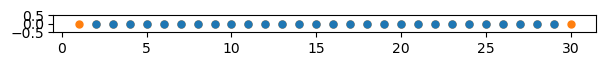

In [59]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
ax.scatter(spinup_shape[0],spinup_shape[1], s = 25)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 25,zorder=-1)
#ax.scatter(X,Y,zorder=-2, s = 25)
ax.set_aspect('equal')
ax.set_ylim(-0.5,Ny-0.5)
ax.set_xlim(-0.5,W+Ny+0.5)
fig.show()
#fig.savefig('shape.pdf')

In [60]:
nbands = 20
momenta, bands = make_bands_x(parameters, number_of_bands = nbands, number_of_points = 2001, kmin = -pi/np.sqrt(2),kmax = pi/np.sqrt(2))

(-2.221441469079183, 2.221441469079183)

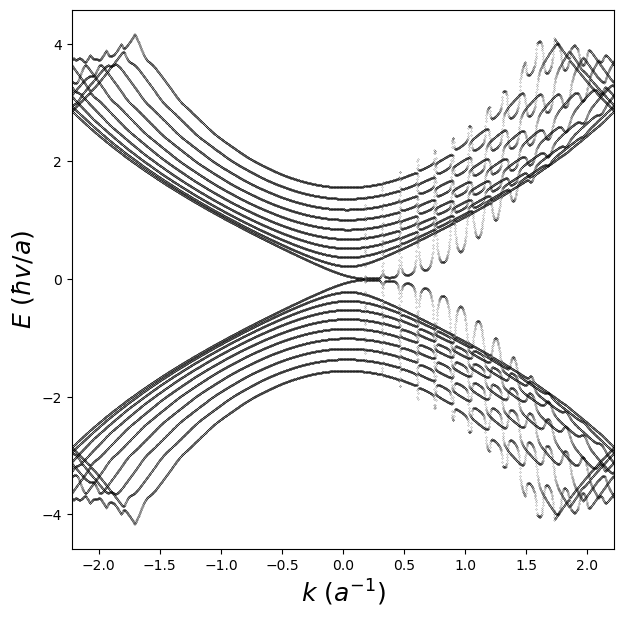

In [61]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
#ax.set_ylim(-1,1)
#ax.set_xlim(-1,1)
ax.set_xlim(-pi/np.sqrt(2),pi/np.sqrt(2))
#fig.savefig('diagonal_antizigzag_small.pdf')

In [107]:
thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
Ny = 20
i = 0### selected value of theta
k = 0
Nx = 3
parameters = dict(
    Nx = Nx,
    Ny = Ny,
    N1 = 0,
    d1 = 0,
    N2 = 0,
    B1 = 0,
    potential = lambda x,y:0.0*np.random.rand(Ny,Nx),
    mass = lambda x,y:0*x,
    disorder = 0,
    ky = k,
    theta = -(pi/2)*(thetas[i]/100),
)

#Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_diag(parameters, return_shape = True)
nbands = 20
momenta, bands = tb.make_bands_x(parameters, number_of_bands = nbands, number_of_points = 2001, kmin = -pi,kmax = pi)

ArpackError: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.

In [ ]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
ax.set_ylim(-1,1)
#ax.set_xlim(-1,1)
#ax.set_xlim(-pi/np.sqrt(2),pi/np.sqrt(2))